In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time 
from datetime import datetime
import warnings

plt.style.use('ggplot')
warnings.filterwarnings('ignore')

start = time.perf_counter()

Only counting activities post Europe, export HeartWatch Workouts from Jul 17 - Today and add the csv to the wd

In [21]:
df = pd.read_csv('HeartWatch-Workouts-20230717-to-20230825.csv')

In [22]:
df = df.drop(['Date', 'from', 'to', 'rpe', 'Load', 'bpm-lo', 'bpm-90%+-%', '90%+-mins',
              'bpm-80-90%-%', '80-90%-mins','bpm-70-80%-%', '70-80%-mins','bpm-60-70%-%',
              '60-70%-mins','bpm-50-60%-%', '50-60%-mins'], axis=1)

# Drop Run w/ Bear
df = df.drop(19)

In [23]:
# Fix Datetime Columns
df['ISO'] = pd.to_datetime(df['ISO'])
df['Duration'] = pd.to_timedelta(df['Duration'])
df['/km'] = pd.to_timedelta(df['/km'])
df['Date'] = df['ISO'].dt.date

df.set_index('ISO', inplace=True) 

wklySUM = pd.DataFrame(df[df['Type'] == 'Running'].groupby(pd.Grouper(freq='W-SUN')).agg('sum'))
wklyAVG = pd.DataFrame(df[df['Type'] == 'Running'].groupby(pd.Grouper(freq='W-SUN')).agg('mean'))

# print(wklySUM.head())
# print(wklyAVG.head())

In [24]:
dfRun = df[df['Type'] == 'Running']
dfBike = df[df['Type'] == 'Cycling']
dfOther = df[~df['Type'].isin(['Running', 'Cycling'])]

# print(dfRun.info())
# print(dfBike.info())
# print(dfOther.head())

In [25]:
# Pace Calculation
# Calculate the total seconds of Duration column
total_seconds = dfRun['Duration'].dt.total_seconds()

# Average Pace from M/S
mps = dfRun['km'].sum()*1000 / total_seconds.sum()
kph = mps * 3.6
mpk = 60 / kph

integer_part = int(mpk)
decimal_part = mpk - integer_part

# Convert decimal part to minutes by dividing by 60
decimal_minutes = round(decimal_part * 60,0)

In [26]:
# Weighted HR
dfRunWght = dfRun

# Convert the time delta to decimal hours and create a new column
dfRunWght["Duration"] = dfRunWght["Duration"].apply(lambda x: x.total_seconds() / 3600)
dfRunWght['Weighted HR'] = dfRunWght['Duration'] * dfRunWght['bpm-Avg.']

# HR/Speed Decimal
dfRun['HR/Speed'] = (dfRun['bpm-Avg.'] / dfRun['km/h']) 

# Cumulative Sum
dfRun['CumKM'] = dfRun['km'].cumsum()

In [27]:
# dfRun.head()

## Graphs

### Running Distance Frequency 

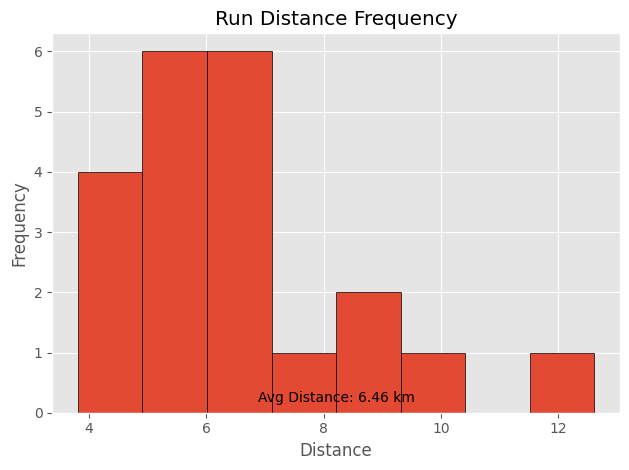

In [28]:
rdf_bins = int(dfRun['km'].max() - dfRun['km'].min())

plt.hist(dfRun['km'], edgecolor='black', bins=rdf_bins)

# Average Distance Text
avg_distance = dfRun['km'].mean()
mid_dist = (dfRun['km'].max() + dfRun['km'].min()) / 2
plt.text(mid_dist, 0.25, f'Avg Distance: {avg_distance:.2f} km',
         ha='center', va='center', fontsize=10, color='black')

plt.title('Run Distance Frequency')
plt.xlabel('Distance')
plt.ylabel('Frequency')
# plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('Graphs/Distance Frequency.png', dpi=300)
plt.show()

### Average Heart Rate Frequency

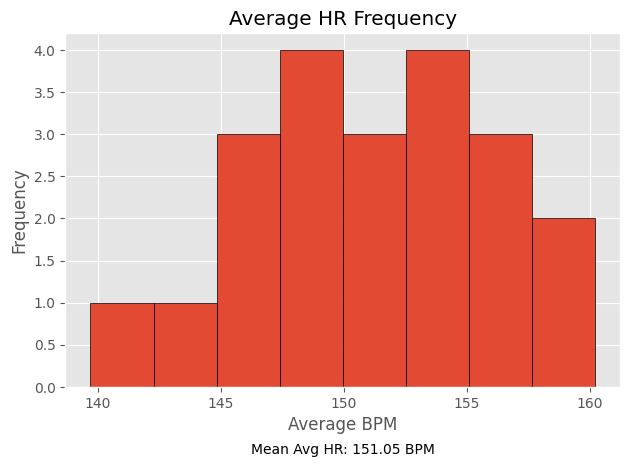

In [39]:
hrf_bins = int((dfRun['bpm-Avg.'].max() - dfRun['bpm-Avg.'].min())/2.5)

plt.hist(dfRun['bpm-Avg.'], edgecolor='black', bins=hrf_bins)

# Average HR Text
avg_hr = dfRun['bpm-Avg.'].mean()
mid_hr = (dfRun['bpm-Avg.'].max() + dfRun['bpm-Avg.'].min()) / 2
plt.text(mid_hr, -.75, f'Mean Avg HR: {avg_hr:.2f} BPM',
         ha='center', va='center', fontsize=10, color='black', transform=plt.gca().transData)

plt.title('Average HR Frequency')
plt.xlabel('Average BPM')
plt.ylabel('Frequency')
# plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('Graphs/HR Frequency.png', dpi=300)
plt.show()

### Average Heart Rate versus Average Speed (km/h)

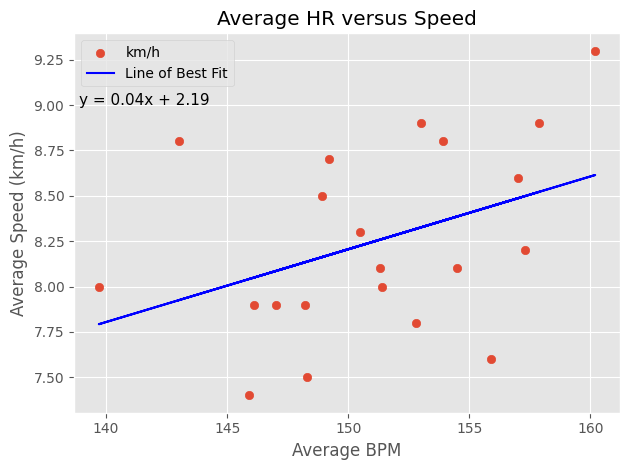

In [30]:
# Line of Best Fit
# Fit a linear regression line to the data
degree = 1
coefficients = np.polyfit(dfRun['bpm-Avg.'], dfRun['km/h'], degree)
slope = coefficients[0]
intercept = coefficients[1]
# Calculate the predicted y-values using the line equation
predicted_y = slope * dfRun['bpm-Avg.'] + intercept
equation = f'y = {slope:.2f}x + {intercept:.2f}'

# Plot
plt.scatter('bpm-Avg.', 'km/h', data=dfRun)
plt.plot(dfRun['bpm-Avg.'], predicted_y, color='blue', label='Line of Best Fit')
plt.xlabel('Average BPM')
plt.ylabel('Average Speed (km/h)')
plt.title('Average HR versus Speed')
plt.text(0.01, 0.81, equation, fontsize=11, transform=plt.gca().transAxes)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('Graphs/SpeedvsHR.png', dpi=300)
plt.show()

### Heart Rate / Speed over Time

Lower is better

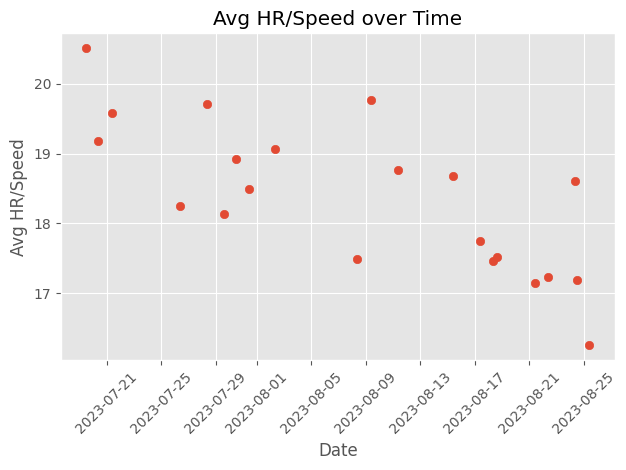

In [31]:
plt.scatter(dfRun.index, y= dfRun['HR/Speed'])
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Avg HR/Speed')
plt.title('Avg HR/Speed over Time')
plt.grid(True)
plt.tight_layout()
plt.savefig('Graphs/HR-Speed over Time.png', dpi=300)
plt.show()

### Distance vs Average Heart Rate


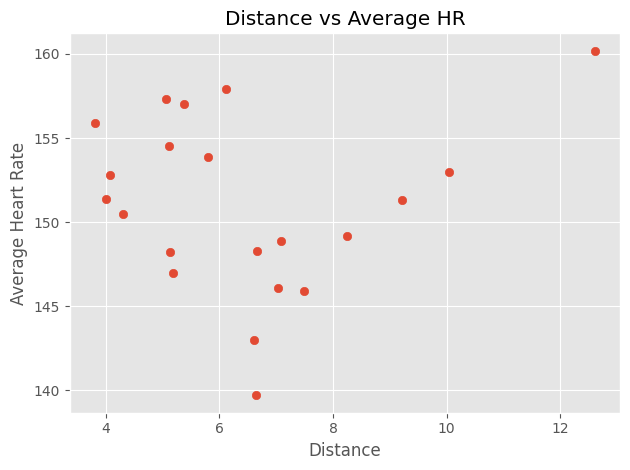

In [32]:
plt.scatter('km', 'bpm-Avg.', data=dfRun)
plt.xlabel('Distance')
plt.ylabel('Average Heart Rate')
plt.title('Distance vs Average HR')
plt.grid(True)
plt.tight_layout()
plt.savefig('Graphs/Distance vs Avg HR.png', dpi=300)

### Duration vs Average Heart Rate

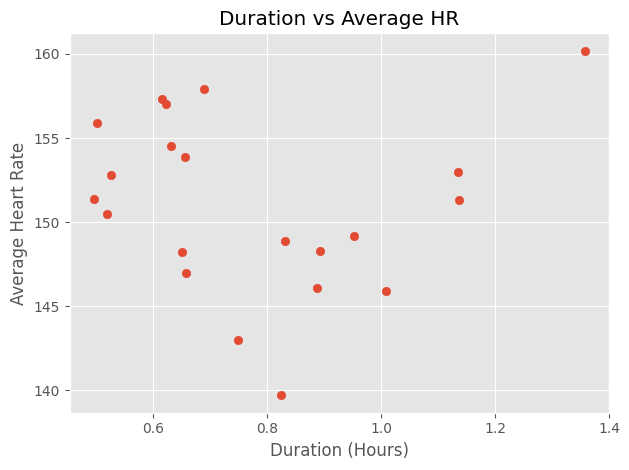

In [33]:
plt.scatter('Duration', 'bpm-Avg.', data=dfRun)
plt.xlabel('Duration (Hours)')
plt.ylabel('Average Heart Rate')
plt.title('Duration vs Average HR')
plt.grid(True)
plt.tight_layout()
plt.savefig('Graphs/Duration vs Avg HR.png', dpi=300)

### Weekly Distance


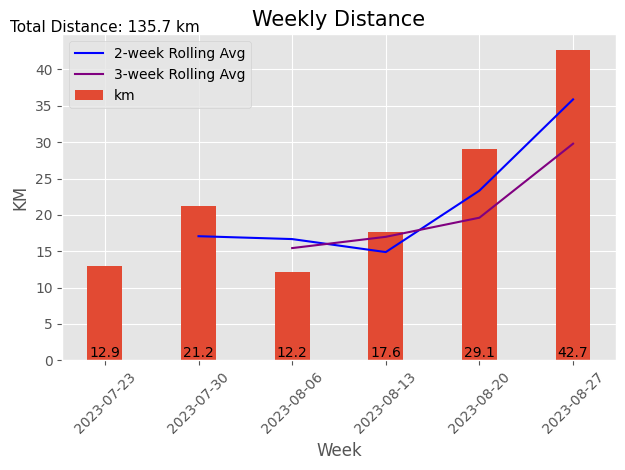

In [34]:
# plt.figure(figsize=(10,6))

# Rolling Average 
rolling_average2 = wklySUM['km'].rolling(window=2).mean()
plt.plot(wklySUM.index, rolling_average2, label='2-week Rolling Avg', color='blue')
rolling_average3 = wklySUM['km'].rolling(window=3).mean()
plt.plot(wklySUM.index, rolling_average3, label='3-week Rolling Avg', color='purple')

# Toal Distance Text
total_distance = wklySUM['km'].sum()
plt.text(wklySUM.index[0], wklySUM['km'].max() + 2, f'Total Distance: {total_distance:.1f} km',
         ha='center', va='bottom', fontsize=11, color='black', transform=plt.gca().transData)

plt.bar(wklySUM.index, wklySUM['km'], label='km', width=2.6)
for idx, value in enumerate(wklySUM['km']):
    plt.text(wklySUM.index[idx], 0, f'{value:.1f}', ha='center', va='bottom',
             fontsize=10, color='black')
    
plt.xlabel('Week')
plt.ylabel('KM')
plt.title('Weekly Distance', fontsize=15)
plt.legend()
plt.xticks(wklySUM.index, wklySUM.index.strftime('%Y-%m-%d'), rotation=45)
plt.tight_layout()
plt.savefig('Graphs/Weekly Distance.png', dpi=300)
plt.show()

### Cumulative Distance

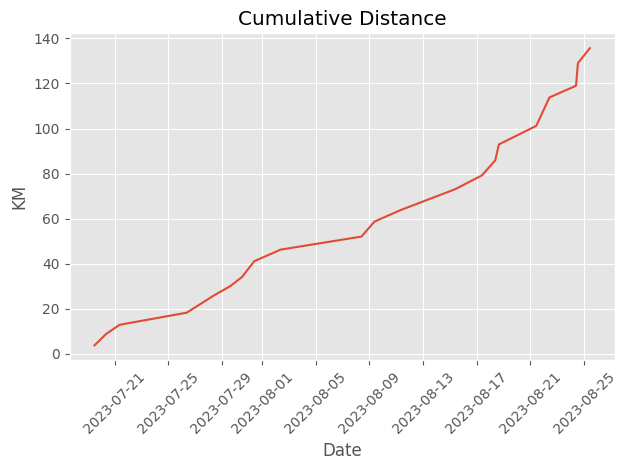

In [35]:
plt.plot(dfRun.index, dfRun['CumKM'])
plt.title('Cumulative Distance')
plt.xlabel('Date')
plt.ylabel('KM')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('Graphs/Cumulative Distance.png', dpi=300)
plt.show()

In [36]:
# Average Duration, Distance, Average HR, Average Max HR Average Calories
avg_dist = round(dfRun['km'].mean(),2)
avg_hr = round(dfRun['bpm-Avg.'].mean(),2)
avg_wght_hr = round(dfRunWght['Weighted HR'].sum() / dfRunWght['Duration'].sum(),2)
avg_maxhr = round(dfRun['bpm-hi'].mean(),2)
avg_cals = round(dfRun['Cals'].mean(),2)
avg_dur = dfRun['Duration'].mean()
avg_ride = round(dfBike['km'].mean())
avg_walk = round(dfOther[dfOther['Type'] == 'Walking']['km'].mean(),2)
avg_hr_ride = round(dfBike['bpm-Avg.'].mean(),2)
avg_max_hr_ride = round(dfBike['bpm-hi'].mean(),2)
avg_hr_walk = round(dfOther[dfOther['Type'] == 'Walking']['bpm-Avg.'].mean(),2)
avg_max_hr_walk = round(dfOther[dfOther['Type'] == 'Walking']['bpm-hi'].mean(),2)
avg_cals_bike = round(dfBike['Cals'].mean(),)
avg_cals_walk = round(dfOther[dfOther['Type'] == 'Walking']['Cals'].mean(),)
avg_speed_bike = dfBike['km/h'].mean()

# Count Runs
num_runs = dfRun['km'].count()
num_rides = dfBike['km'].count()
num_walks = dfOther[dfOther['Type'] == 'Walking']['km'].count()
ovr_5k = dfRun[dfRun['km'] >=5].count()['km']
povr_5k = round(ovr_5k / num_runs *100,2)
ovr_10k = dfRun[dfRun['km'] >=10].count()['km']
povr_10k = round(ovr_10k / num_runs *100,2)
runs_per_day = round(num_runs / dfRun['Date'].nunique(),3)
date_cts = dfRun['Date'].value_counts()
dbl_days = date_cts[date_cts > 1].count()

# Maximums
max_dur = dfRun['Duration'].max()
max_dist = dfRun['km'].max()
max_avghr = dfRun['bpm-Avg.'].max()
max_maxhr = dfRun['bpm-hi'].max()
max_cals = dfRun['Cals'].max()
max_bike = dfBike['km'].max()
max_walk = dfOther[dfOther['Type'] == 'Walking']['km'].max()
max_bike_cals = round(dfBike['Cals'].max(),)
max_walk_cals = round(dfOther[dfOther['Type'] == 'Walking']['Cals'].max(),)

# Totals
tot_dist = round(dfRun['km'].sum(),2)
tot_dur = dfRun['Duration'].sum()
tot_cals = round(dfRun['Cals'].sum(),)
tot_cals = f'{tot_cals:,}'
tot_bike = dfBike['km'].sum()
tot_walk = dfOther[dfOther['Type'] == 'Walking']['km'].sum()
tot_bike_cals = round(dfBike['Cals'].sum(),)
tot_walk_cals = round(dfOther[dfOther['Type'] == 'Walking']['Cals'].sum(),)

# Medians
med_dist = round(dfRun['km'].median(),2)
med_avg_hr = round(dfRun['bpm-Avg.'].median(),2)
med_max_hr = round(dfRun['bpm-hi'].median(),2)
med_cals = round(dfRun['Cals'].median(),)
med_ride = round(dfBike['km'].median(),2)
med_walk = round(dfOther[dfOther['Type'] == 'Walking']['km'].median(),2)
med_avg_hr_ride = round(dfBike['bpm-Avg.'].median(),2)
med_max_hr_ride = round(dfBike['bpm-hi'].median(),2)
med_avg_hr_walk = round(dfOther[dfOther['Type'] == 'Walking']['bpm-Avg.'].median(),2)
med_max_hr_walk = round(dfOther[dfOther['Type'] == 'Walking']['bpm-hi'].median(),2)
med_cals_bike = round(dfBike['Cals'].median(),)
med_cals_walk = round(dfOther[dfOther['Type'] == 'Walking']['Cals'].median(),)
med_speed_bike = dfBike['km/h'].median()

# Durations to Time Format
avg_dur_h = int(avg_dur)
max_dur_h = int(max_dur)
tot_dur_h = int(tot_dur)

avg_dur_m_dec = (avg_dur - avg_dur_h)*60
max_dur_m_dec = (max_dur - max_dur_h)*60
tot_dur_m_dec = (tot_dur - tot_dur_h)*60

avg_dur_m = int(avg_dur_m_dec)
max_dur_m = int(max_dur_m_dec)
tot_dur_m = int(tot_dur_m_dec)

avg_dur_s = int((avg_dur_m_dec - avg_dur_m)*60)
max_dur_s = int((max_dur_m_dec - max_dur_m)*60)
tot_dur_s = int((tot_dur_m_dec - tot_dur_m)*60)

avg_dur_f = str(avg_dur_h) + ':' + str(avg_dur_m) + ':' + str(avg_dur_s)
max_dur_f = str(max_dur_h) + ':' + str(max_dur_m) + ':' + str(max_dur_s)
tot_dur_f = str(tot_dur_h) + ':' + str(tot_dur_m) + ':' + str(tot_dur_s)

## Running Stats

In [37]:
print('----------------------------')
print(f'Runs: {num_runs}')
print(f'Runs over 5k(%): {ovr_5k} ({povr_5k}%)')
print(f'Runs over 10k(%): {ovr_10k} ({povr_10k}%)')
print(f'Double Days: {dbl_days}')
print(f'Runs per Day: {runs_per_day}')

print('----------------------------')
print(f'Average Duration: {avg_dur_f}')
print(f'Average Distance: {avg_dist}')
print(f"Average Pace: {integer_part}:{decimal_minutes}")
print(f'Average Weighted HR: {avg_wght_hr}')
print(f'Average HR: {avg_hr}')
print(f'Average Max HR: {avg_maxhr}')
print(f'Average Calories: {avg_cals}')

print('----------------------------')
print(f'Max Duration: {max_dur_f}')
print(f'Max Distance: {max_dist}')
print(f'Max Average HR: {max_avghr}')
print(f'Max Max HR: {max_maxhr}')
print(f'Max Calories: {max_cals}')

print('----------------------------')
print(f'Median Distance: {med_dist}')
print(f'Median Avg HR: {med_avg_hr}')
print(f'Median Max HR: {med_max_hr}')
print(f'Median Calories: {med_cals}')

print('----------------------------')
print(f'Total Duration: {tot_dur_f}')
print(f'Total Distance: {tot_dist}')
print(f'Total Running Calories: {tot_cals}')

----------------------------
Runs: 21
Runs over 5k(%): 17 (80.95%)
Runs over 10k(%): 2 (9.52%)
Double Days: 2
Runs per Day: 1.105
----------------------------
Average Duration: 0:46:41
Average Distance: 6.46
Average Pace: 7:14.0
Average Weighted HR: 150.99
Average HR: 151.05
Average Max HR: 171.52
Average Calories: 530.05
----------------------------
Max Duration: 1:21:26
Max Distance: 12.61
Max Average HR: 160.2
Max Max HR: 218.0
Max Calories: 1008.3
----------------------------
Median Distance: 6.12
Median Avg HR: 151.3
Median Max HR: 168.0
Median Calories: 499
----------------------------
Total Duration: 16:20:37
Total Distance: 135.66
Total Running Calories: 11,131


## Riding/Walking Stats

In [38]:
print(f'Rides: {num_rides}')
print(f'Average Distance: {avg_ride}')
print(f'Average HR: {avg_hr_ride}')
print(f'Average Max HR: {avg_max_hr_ride}')
print(f'Average Calories: {avg_cals_bike}')
print(f'Average Speed: {avg_speed_bike}')
print(f'Median Distance: {med_ride}')
print(f'Median Avg HR: {med_avg_hr_ride}')
print(f'Median Max HR: {med_max_hr_ride}')
print(f'Median Calories: {med_cals_bike}')
print(f'Median Speed: {med_speed_bike}')
print('----------------------------')
print(f'Walks: {num_walks}')
print(f'Average Distance: {avg_walk}')
print(f'Average HR: {avg_hr_walk}')
print(f'Average Max HR: {avg_max_hr_walk}')
print(f'Average Calories: {avg_cals_walk}')
print(f'Median Distance: {med_walk}')
print(f'Median Avg HR: {med_avg_hr_walk}')
print(f'Median Max HR: {med_max_hr_walk}')
print(f'Median Calories: {med_cals_walk}')
print('----------------------------')
print('Maximums')
print(f'Max Bike Distance: {max_bike}')
print(f'Max Bike Calories: {max_bike_cals}')
print(f'Max Walk Distance: {max_walk}')
print(f'Max Walk Calories: {max_walk_cals}')
print('----------------------------')
print("Totals")
print(f'Total Bike Distance: {tot_bike}')
print(f'Total Bike Calories: {tot_bike_cals}')
print(f'Total Walk Distance: {tot_walk}')
print(f'Total Walk Calories: {tot_walk_cals}')
print('----------------------------')
print(f'Runtime: {round(time.perf_counter() - start,2)}s')


Rides: 5
Average Distance: 29
Average HR: 140.42
Average Max HR: 179.0
Average Calories: 612
Average Speed: 17.82
Median Distance: 31.5
Median Avg HR: 140.9
Median Max HR: 182.0
Median Calories: 661
Median Speed: 19.0
----------------------------
Walks: 6
Average Distance: 3.66
Average HR: 112.1
Average Max HR: 131.5
Average Calories: 214
Median Distance: 3.3
Median Avg HR: 114.4
Median Max HR: 130.5
Median Calories: 202
----------------------------
Maximums
Max Bike Distance: 35.16
Max Bike Calories: 829
Max Walk Distance: 6.42
Max Walk Calories: 406
----------------------------
Totals
Total Bike Distance: 143.8
Total Bike Calories: 3061
Total Walk Distance: 21.93
Total Walk Calories: 1286
----------------------------
Runtime: 2.28s
